In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skbio.stats import subsample_counts
from skbio.stats.composition import ancom
from skbio.stats.distance import permanova, mantel
from skbio.stats.composition import ancom, closure
from matplotlib.gridspec import GridSpec

from skbio import TreeNode
import biom
import seaborn as sns
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
map_fp = '../data/Payami_parkinsons_qiime_mapping_corrected_drugs_spouse.txt'
map_ = pd.read_csv(map_fp, 
                   sep='\t',
                   dtype=str, 
                   encoding = "ISO-8859-1",
                   na_values=['NA', 'Not applicable', 'not applicable', "Don't Know"]
                   )
map_.set_index('#SampleID', inplace=True) 

In [3]:
def exploding_panda(_bt):
    """BIOM->Pandas dataframe converter

    Parameters
    ----------
    _bt : biom.Table
        BIOM table

    Returns
    -------
    pandas.DataFrame
        The BIOM table converted into a DataFrame
        object.

    References
    ----------
    Based on this answer on SO:
    http://stackoverflow.com/a/17819427/379593
    
    Function written by Yoshiki Vazquez Baeza 
    (from https://github.com/biocore/biom-format/issues/622)
    """
    m = _bt.matrix_data
    data = [pd.SparseSeries(m[i].toarray().ravel()) for i in np.arange(m.shape[0])]
    out = pd.SparseDataFrame(data, index=_bt.ids('observation'),
                             columns=_bt.ids('sample'))

    return out

In [4]:
#otu_biom = biom.load_table('../data/337_otu_table.biom')
otu_biom = biom.load_table('../data/filtered_otu_5k.biom')
otu_ = exploding_panda(otu_biom).to_dense().T
otu_ = otu_.astype(np.int)

In [5]:
def age_f(x):
    try:
        if float(x)<70.5:
            return 'Less than 70.5 years'
        else:
            return "Greater than 70.5 years"
    except:
        return np.nan
map_['age_cat'] = map_['age'].apply(age_f)

def bmi_f(x):
    try:
        if float(x)<18.5:
            return 'Underweight'
        elif float(x)>= 18.5 and float(x) < 25:        
            return "Normal"
        elif float(x) >= 25 and float(x) < 30:
            return "Overweight"
        else:
            return "Obese"
    except:
        return np.nan
map_['bmi_cat'] = map_['bmi'].apply(bmi_f)

def transit_f(x):
    try:
        if int(x)<3:
            return 'Less than 3 days'
        else:
            return "More than 3 days"
    except:
        return np.nan
map_['stool_travel_time_cat'] = map_['stool_travel_time'].apply(transit_f)

def fruit_f(x):
    if not isinstance(x, str):
        return np.nan
    else:
        if x=='At least once a day':
            return 'Daily'
        else:
            return "Not Daily"
map_['fruits_or_vegetables_cat'] = map_['fruits_or_vegetables'].apply(fruit_f)

def alcohol_f(x):
    if not isinstance(x, str):
        return np.nan
    else:
        if 'day' in x:
            return 'Daily'
        else:
            return "Not Daily"

map_['alcohol_how_much_cat'] = map_['alcohol_how_much'].apply(alcohol_f)

def spouse_f(x):
    try:
        if int(x)==1:
            return 'Spousal'
        else:
            return "Non-spousal"
    except:
        return np.nan
map_['spouse'] = map_['spouse'].apply(spouse_f)


def disease_duration_quartile_f(x):
    try:
        if int(x)<9:
            return 'Less than 9 years'
        #elif int(x)>9 and int(x)<14:
        #    return '9 to 14 years'
        #elif int(x) > 14 and int(x) < 17:
        #    return '14 to 17 years'
        else:
            return "Greater than 9 years"
    except:
        return np.nan
map_['parkinson_disease_duration_cat'] = map_['parkinson_disease_duration'].apply(disease_duration_quartile_f)




In [6]:
map_ = map_.dropna(subset=['case_control'])

In [7]:
#otu_ = otu_.loc[otu_.sum(axis=1)>5000, :]
#otu_ = otu_.apply(lambda x: subsample_counts(x, n=5000), axis=1)
otu_ = otu_.loc[:, (otu_ > 0).sum(0) > 0.1*len(map_.index)].astype(float)
otu_ = otu_.loc[:, otu_.sum(axis=0)>0] 
# drop the bloody contaminant
#otu_ = otu_.drop('4448331', 1)

In [8]:
# Defines the samples to filter
keep_samples = (set(map_.index).intersection(set(otu_.index)) - 
                {'10122.BLANK.1.1A', '10122.BLANK.3.3C', '10122.BLANK.4.12H', 
                 '10122.BLANK.4.4E'})

In [9]:
# Filters the map and distance matrices
map_ = map_.loc[keep_samples]
otu_ = otu_.loc[map_.index]
map_ = map_.sort_index()
otu_ = otu_.sort_index()

In [10]:
# Next we convert the whole thing to porportions
otu_props = pd.DataFrame(closure(otu_.values + 1),
                         index=otu_.index,
                         columns=otu_.columns)

In [11]:
ids = list(map(str, [4481427, 180999, 4457438, 4325096, 173969, 
                     4416570, 4465907, 176306, 4381430, 4481131]))

In [12]:
case_control_df = otu_props[ids]
case_control_df.loc[:, 'Treatment'] = map_.loc[:, 'case_control']

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
mdf = pd.melt(case_control_df, var_name='OTU', value_name='Proportion', id_vars='Treatment')

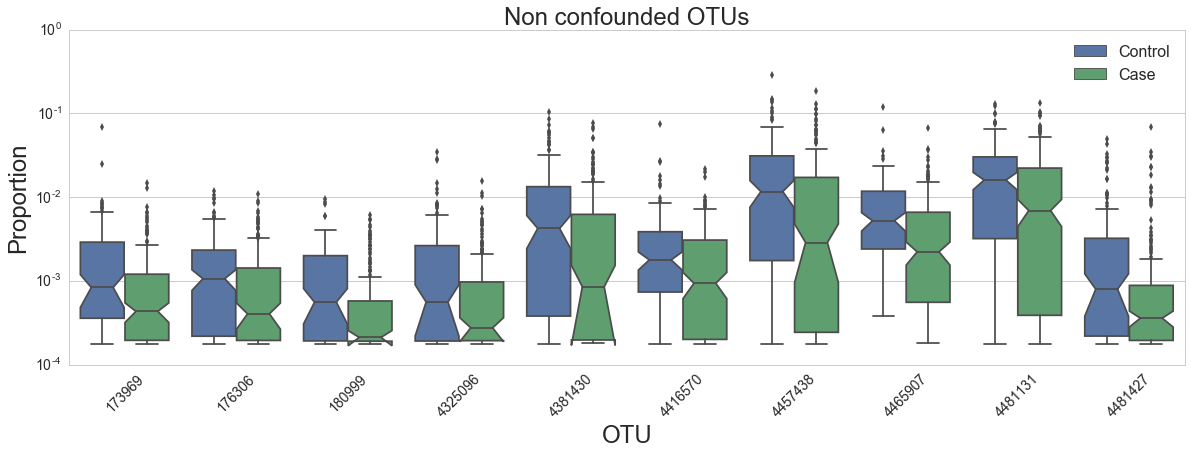

In [14]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 6))
ax = sns.boxplot(data=mdf, x='OTU', y='Proportion', hue='Treatment', notch=True)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, fontsize=14)
ax.set_yticklabels(labels=ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('OTU', fontsize=24)
ax.set_ylabel('Proportion', fontsize=24)
ax.legend(fontsize=14)
ax.set_title('Non confounded OTUs', fontsize=24)
ax.legend(fontsize=16)
fig.savefig('../results/nonconfounding_OTUs.svg')
fig.savefig('../results/nonconfounding_OTUs.png')

#plt.tick_params(axis='both', which='major', labelsize=14)

In [15]:
ids = list(map(str, [4352657, 173969, 4347159, 4365130, 4347159]))

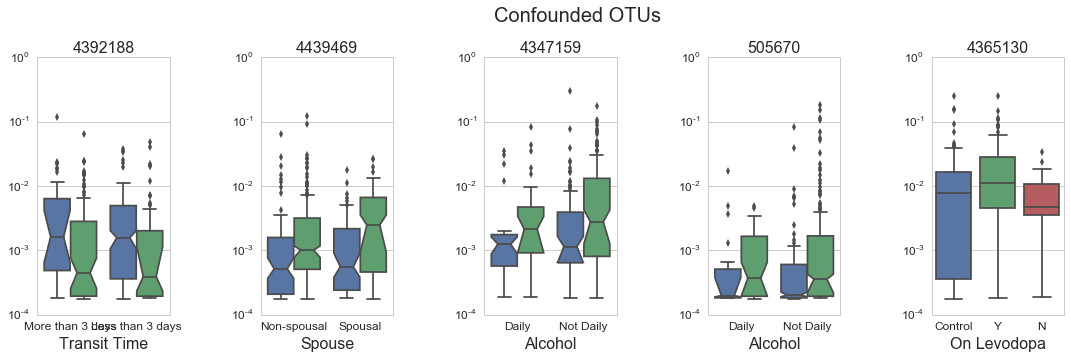

In [111]:
fig = plt.figure(figsize=(20, 5))
gs = GridSpec(100, 100)
ax1 = fig.add_subplot(gs[:, :12]) 
ax2 = fig.add_subplot(gs[:, 20:32]) 
ax3 = fig.add_subplot(gs[:, 40:52]) 
ax4 = fig.add_subplot(gs[:, 60:72]) 
ax5 = fig.add_subplot(gs[:, 80:92]) 

confounding_df1 = pd.DataFrame(otu_props[ids[0]], index=otu_props.index)
confounding_df1['Treatment'] = map_.loc[:, 'case_control']
confounding_df1['stool_travel_time_cat'] = map_.loc[:, 'stool_travel_time_cat']
confounding_df1 = confounding_df1.dropna()
sns.boxplot(data=confounding_df1, x='stool_travel_time_cat', y=ids[0], hue='Treatment', notch=True, ax=ax1,
            bootstrap=1000)
ax1.set_xlabel('Transit Time', fontsize=16)
ax1.set_xticklabels(labels=ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(labels=ax1.get_yticklabels(), fontsize=12)
ax1.set_ylabel("")
ax1.set_yscale('log')
ax1.set_title(ids[0], fontsize=16)
ax1.legend_.remove()


confounding_df2 = pd.DataFrame(otu_props[ids[1]], index=otu_props.index)
confounding_df2['Treatment'] = map_.loc[:, 'case_control']
confounding_df2['spouse'] = map_.loc[:, 'spouse']
confounding_df2 = confounding_df2.dropna()
sns.boxplot(data=confounding_df2, x='spouse', y=ids[1], hue='Treatment', notch=True, ax=ax2,
            bootstrap=1000)
ax2.set_xlabel('Spouse', fontsize=16)
ax2.set_xticklabels(labels=ax2.get_xticklabels(), fontsize=12)
ax2.set_yticklabels(labels=ax2.get_yticklabels(), fontsize=12)
ax2.set_ylabel("")
ax2.set_yscale('log')
ax2.set_title(ids[1], fontsize=16)
ax2.legend_.remove()

confounding_df3 = pd.DataFrame(otu_props[ids[2]], index=otu_props.index)
confounding_df3['Treatment'] = map_.loc[:, 'case_control']
confounding_df3['alcohol_how_much_cat'] = map_.loc[:, 'alcohol_how_much_cat']
confounding_df3 = confounding_df3.dropna()
sns.boxplot(data=confounding_df3, x='alcohol_how_much_cat', y=ids[2], hue='Treatment', notch=True, ax=ax3)
ax3.set_xlabel('Alcohol', fontsize=16)
ax3.set_xticklabels(labels=ax3.get_xticklabels(), fontsize=12)
ax3.set_yticklabels(labels=ax3.get_yticklabels(), fontsize=12)
ax3.set_ylabel("")
ax3.set_yscale('log')
ax3.set_title(ids[2], fontsize=16)
ax3.legend_.remove()

confounding_df4 = pd.DataFrame(otu_props[ids[3]], index=otu_props.index)
confounding_df4['Treatment'] = map_.loc[:, 'case_control']
confounding_df4['alcohol_how_much_cat'] = map_.loc[:, 'alcohol_how_much_cat']
confounding_df4 = confounding_df4.dropna()
sns.boxplot(data=confounding_df4, x='alcohol_how_much_cat', y=ids[3], hue='Treatment', notch=True, ax=ax4,
            bootstrap=1000)
ax4.set_xlabel('Alcohol', fontsize=16)
ax4.set_xticklabels(labels=ax4.get_xticklabels(), fontsize=12)
ax4.set_yticklabels(labels=ax4.get_yticklabels(), fontsize=12)
ax4.set_yscale('log')
ax4.set_ylabel("")
ax4.set_title(ids[3], fontsize=16)
ax4.legend_.remove()
fig.subplots_adjust(top=0.84)
fig.suptitle('Confounded OTUs', size=20)

confounding_df5 = pd.DataFrame(otu_props[ids[4]], index=otu_props.index)
confounding_df5['On Levodopa'] = map_.carbidopa_levodopa
confounding_df5 = pd.melt(confounding_df5, id_vars=ids[4], value_name='Treatment')
confounding_df5.loc[pd.isnull(confounding_df5['Treatment']), 'Treatment'] = 'Control'

idx = confounding_df5['Treatment'].apply(lambda x: x != 'not provided')
confounding_df5 = confounding_df5.loc[idx]

sns.boxplot(data=confounding_df5, x='Treatment', y=ids[4], ax=ax5)
ax5.set_xlabel('On Levodopa', fontsize=16)
ax5.set_xticklabels(labels=ax5.get_xticklabels(), fontsize=12)
ax5.set_yticklabels(labels=ax5.get_yticklabels(), fontsize=12)
ax5.set_yscale('log')
ax5.set_ylabel("")
ax5.set_title(ids[4], fontsize=16)
#ax5.legend_.remove()
fig.subplots_adjust(top=0.84)
fig.suptitle('Confounded OTUs', size=20)

fig.savefig('../results/confounding_OTUs.svg')
fig.savefig('../results/confounding_OTUs.png')


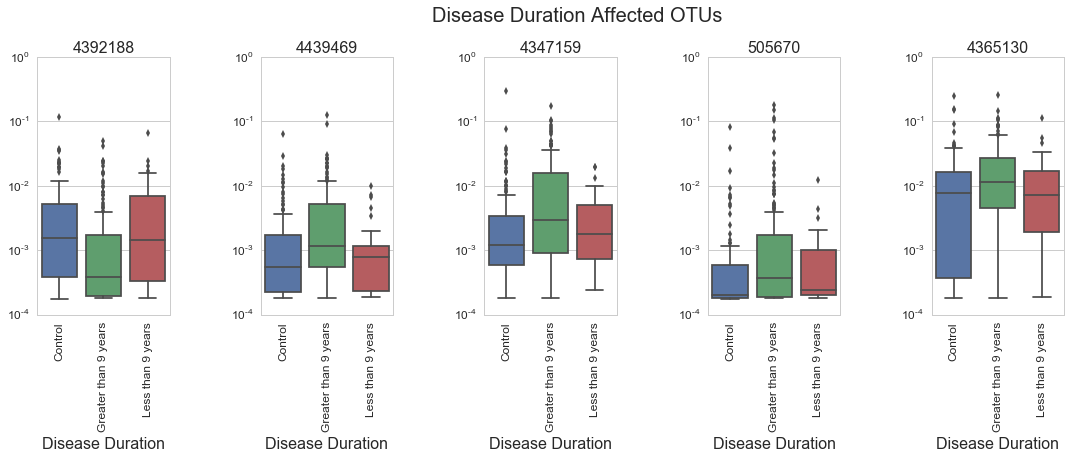

In [109]:
ids = list(map(str, [4392188, 4439469, 4347159, 505670, 4365130]))

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(100, 100)
ax1 = fig.add_subplot(gs[:, :12]) 
ax2 = fig.add_subplot(gs[:, 20:32]) 
ax3 = fig.add_subplot(gs[:, 40:52]) 
ax4 = fig.add_subplot(gs[:, 60:72]) 
ax5 = fig.add_subplot(gs[:, 80:92]) 
idx = pd.isnull(map_['parkinson_disease_duration_cat'])
_idx = np.logical_not(pd.isnull(map_['parkinson_disease_duration_cat']))

confounding_df1 = pd.DataFrame(otu_props[ids[0]], index=otu_props.index)
confounding_df1.loc[:, 'parkinson_disease_duration_cat'] = map_['parkinson_disease_duration_cat']
confounding_df1.loc[idx, 'parkinson_disease_duration_cat'] = 'Control' 
sns.boxplot(data=confounding_df1, x='parkinson_disease_duration_cat', y=ids[0], 
            ax=ax1)
ax1.set_xlabel('Disease Duration', fontsize=16)
ax1.set_xticklabels(labels=ax1.get_xticklabels(), fontsize=12, rotation=90)
ax1.set_yticklabels(labels=ax1.get_yticklabels(), fontsize=12)
ax1.set_ylabel("")

ax1.set_yscale('log')
ax1.set_title(ids[0], fontsize=16)



confounding_df2 = pd.DataFrame(otu_props[ids[1]], index=otu_props.index)
confounding_df2.loc[:, 'parkinson_disease_duration_cat'] = map_['parkinson_disease_duration_cat']
confounding_df2.loc[idx, 'parkinson_disease_duration_cat'] = 'Control' 
sns.boxplot(data=confounding_df2, x='parkinson_disease_duration_cat', y=ids[1], 
            ax=ax2)
ax2.set_xlabel('Disease Duration', fontsize=16)
ax2.set_xticklabels(labels=ax2.get_xticklabels(), fontsize=12, rotation=90)
ax2.set_yticklabels(labels=ax2.get_yticklabels(), fontsize=12)
ax2.set_ylabel("")

ax2.set_yscale('log')
ax2.set_title(ids[1], fontsize=16)

confounding_df3 = pd.DataFrame(otu_props[ids[2]], index=otu_props.index)
confounding_df3.loc[:, 'parkinson_disease_duration_cat'] = map_['parkinson_disease_duration_cat']
confounding_df3.loc[idx, 'parkinson_disease_duration_cat'] = 'Control' 
sns.boxplot(data=confounding_df3, x='parkinson_disease_duration_cat', y=ids[2], 
            ax=ax3)
ax3.set_xlabel('Disease Duration', fontsize=16)
ax3.set_xticklabels(labels=ax3.get_xticklabels(), fontsize=12, rotation=90)
ax3.set_yticklabels(labels=ax3.get_yticklabels(), fontsize=12)
ax3.set_ylabel("")

ax3.set_yscale('log')
ax3.set_title(ids[2], fontsize=16)


confounding_df4 = pd.DataFrame(otu_props[ids[3]], index=otu_props.index)
confounding_df4.loc[:, 'parkinson_disease_duration_cat'] = map_['parkinson_disease_duration_cat']
confounding_df4.loc[idx, 'parkinson_disease_duration_cat'] = 'Control' 
sns.boxplot(data=confounding_df4, x='parkinson_disease_duration_cat', y=ids[3],
            ax=ax4)
ax4.set_xlabel('Disease Duration', fontsize=16)
ax4.set_xticklabels(labels=ax4.get_xticklabels(), fontsize=12, rotation=90)
ax4.set_yticklabels(labels=ax4.get_yticklabels(), fontsize=12)
ax4.set_ylabel("")

ax4.set_yscale('log')
ax4.set_title(ids[3], fontsize=16)


confounding_df5 = pd.DataFrame(otu_props[ids[4]], index=otu_props.index)
confounding_df5.loc[:, 'parkinson_disease_duration_cat'] = map_['parkinson_disease_duration_cat']
confounding_df5.loc[idx, 'parkinson_disease_duration_cat'] = 'Control' 
sns.boxplot(data=confounding_df5, x='parkinson_disease_duration_cat', y=ids[4],
            ax=ax5)
ax5.set_xlabel('Disease Duration', fontsize=16)
ax5.set_xticklabels(labels=ax4.get_xticklabels(), fontsize=12, rotation=90)
ax5.set_yticklabels(labels=ax4.get_yticklabels(), fontsize=12)
ax5.set_ylabel("")

ax5.set_yscale('log')
ax5.set_title(ids[4], fontsize=16)

fig.subplots_adjust(top=0.84)
fig.suptitle('Disease Duration Affected OTUs', size=20)

fig.savefig('../results/disease_duration_OTUs.svg')
fig.savefig('../results/disease_duration_OTUs.png')


In [72]:
from scipy.stats import f_oneway
def logratio_test(x, y, cats):
    """
    x: np.array, int
       OTU counts
    y: np.array, int
       OTU counts
    cat: np.array, str
       Categorical vector
    """
    z = np.log((x+1)/ (y+1))
    grps = [z[cats[cats==c]] for c in set(cats)]
    return f_oneway(*grps)